# Emotion detection
`Maria Magdalena Balos`

Link to the dataset: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer 

---

In [1]:
%env CUDA_VISIBLE_DEVICES=-1

env: CUDA_VISIBLE_DEVICES=-1


In [2]:
import tensorflow as tf

2024-11-20 15:42:40.301331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732117360.311771   93603 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732117360.314986   93603 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 15:42:40.325620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.config.list_physical_devices('GPU')

2024-11-20 15:42:41.635334: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-20 15:42:41.635353: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: tardigrade
2024-11-20 15:42:41.635357: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: tardigrade
2024-11-20 15:42:41.635394: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 530.30.2
2024-11-20 15:42:41.635407: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 530.30.2
2024-11-20 15:42:41.635410: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 530.30.2


[]

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Download the data

If you want to download the dataset uncoment the bash commands (the ones starting with `!`) and run them.

In [5]:
# Create a new hidden folder in home
# ! mkdir ~/.kaggle

In [6]:
# Copy the token authentication (kaggle.json) downloaded from Kaggle in the recently created folder
# ! cp kaggle.json ~/.kaggle/

In [7]:
# Give permisions to the recently added file
# ! chmod 600 ~/.kaggle/kaggle.json

In [8]:
# List all the datasets available in Kaggle
# ! kaggle datasets list

Create a new data directory to save the dataset

In [9]:
# ! mkdir ./data

Download the dataset

In [10]:
# ! kaggle datasets download ananthu017/emotion-detection-fer -p ./data

Unzip the data

In [11]:
# !unzip /data/emotion-detection-fer.zip

---

## Library imports

In [12]:
import time
import os
import numpy as np

# Image processing
from PIL import Image
import matplotlib.pyplot as plt

# Deep learning
import tensorflow as tf

# Convolutional Neural Network
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

# Plot the model schema
from IPython.display import SVG
from keras.utils import model_to_dot

# Save the data
from datetime import datetime
import json

# Transfer learning
from keras.models import Model

---

## Data exploration

### Train data

Explore the categories available in the training data.

In [13]:
categories_name_train = os.listdir("./data/train/")
print(f"The categories available are in the train data are: \n   {categories_name_train}")
print(f"The training dataset has {len(categories_name_train)} categories.")

The categories available are in the train data are: 
   ['fearful', 'neutral', 'sad', 'happy', 'disgusted', 'angry', 'surprised']
The training dataset has 7 categories.


Check the quantity of images in each category available in the training data.

In [14]:
for i in range(len(categories_name_train)):
    path = f"./data/train/{categories_name_train[i]}"
    print(f"The category {categories_name_train[i]} has {len(os.listdir(path))} images.")

The category fearful has 4097 images.
The category neutral has 4965 images.
The category sad has 4830 images.
The category happy has 7215 images.
The category disgusted has 436 images.
The category angry has 3995 images.
The category surprised has 3171 images.


Plot 4 random images from each of the categories in the training data

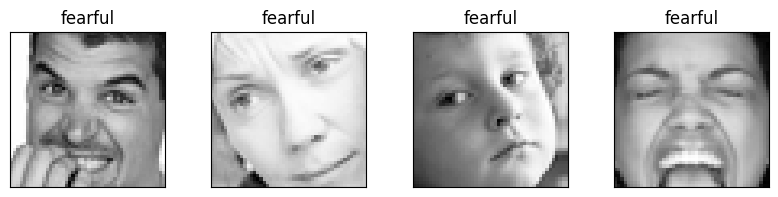

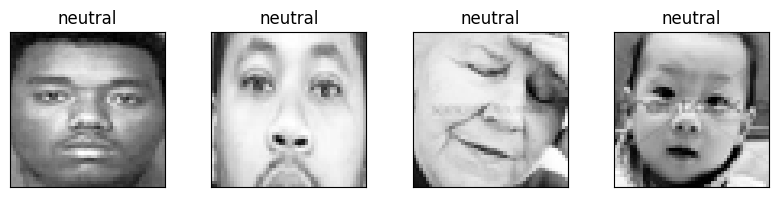

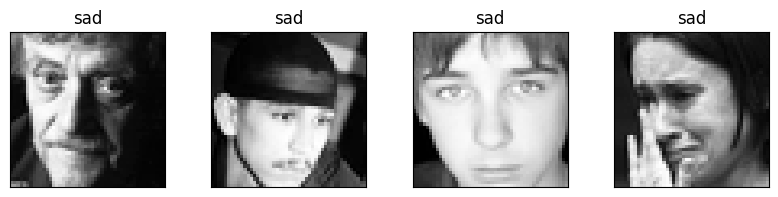

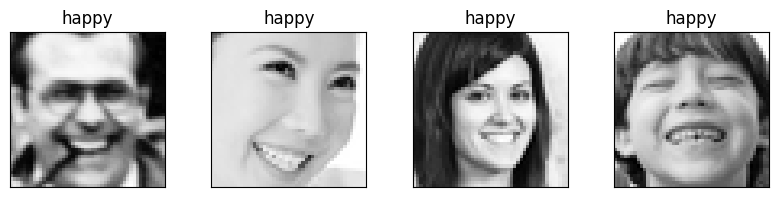

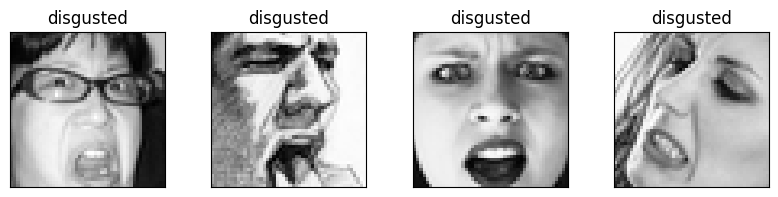

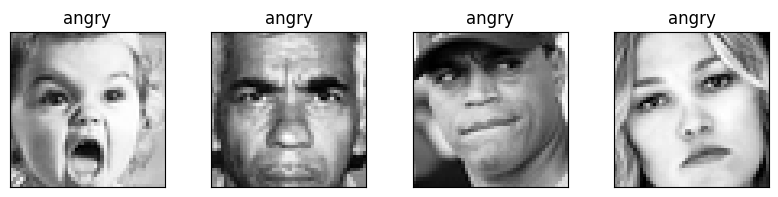

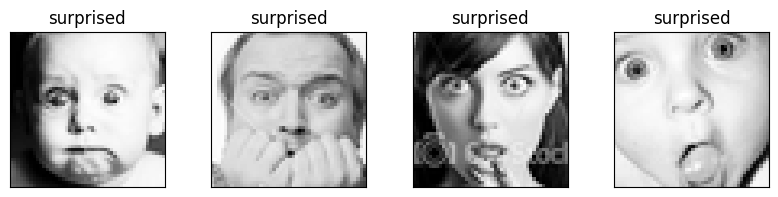

In [15]:
for i in range(len(categories_name_train)):
    plt.figure(figsize=(8,10))
    path = f"./data/train/{categories_name_train[i]}"
    
    for j in range(1,5):
        plt.subplot(3,4,j)
        plt.tight_layout()
        rand_img = Image.open(path +'/'+ np.random.choice(sorted(os.listdir(path))))
        plt.imshow(rand_img, cmap='Greys_r')

        # Don't print the X and Y coordinates on the side of the images.
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{categories_name_train[i]}")

### Test data

Explore the categories available in the testing data.

In [16]:
categories_name_test = os.listdir("./data/test/")
print(f"The categories available are in the test data are: \n   {categories_name_test}")
print(f"The test dataset has {len(categories_name_test)} categories.")

The categories available are in the test data are: 
   ['fearful', 'neutral', 'sad', 'happy', 'disgusted', 'angry', 'surprised']
The test dataset has 7 categories.


Check if the categories categories available in the train are also in test, if not raise an error:

In [17]:
for category in categories_name_train:
    if category not in categories_name_test:
        raise ValueError("The categories available in train doesn't match the test data.")

Check if the number of categories are the same in train and test, if not, raise an error:

In [18]:
if len(categories_name_train) != len(categories_name_test):
    raise ValueError("The lenght of the train and test categories doesn't match.")

Check the categories available in the test dataset.

In [19]:
for i in range(len(categories_name_test)):
    path = f"./data/test/{categories_name_test[i]}"
    print(f"The category {categories_name_test[i]} has {len(os.listdir(path))} images.")

The category fearful has 1024 images.
The category neutral has 1233 images.
The category sad has 1247 images.
The category happy has 1774 images.
The category disgusted has 111 images.
The category angry has 958 images.
The category surprised has 831 images.


Plot 4 random images from each of the categories in the test data

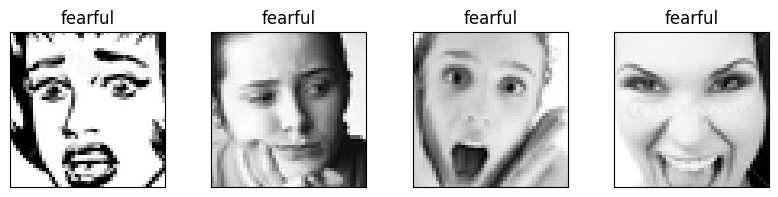

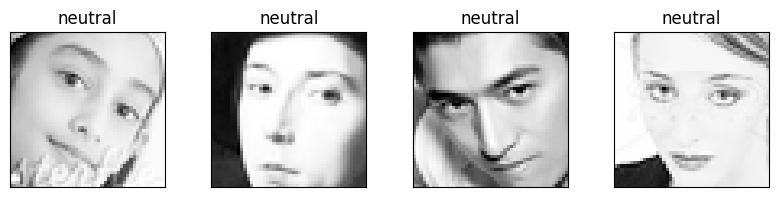

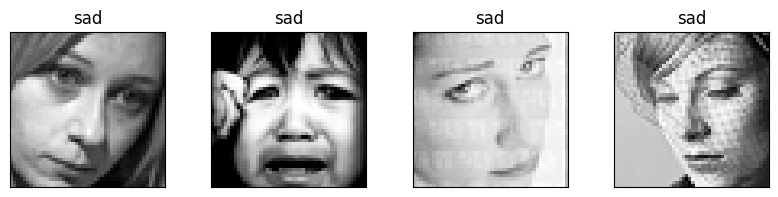

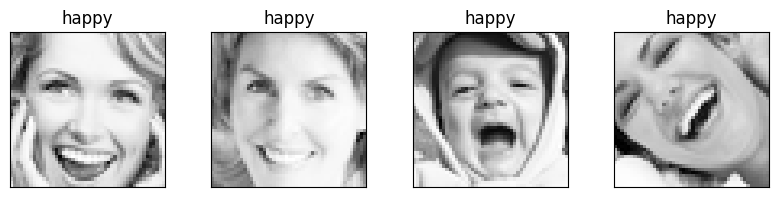

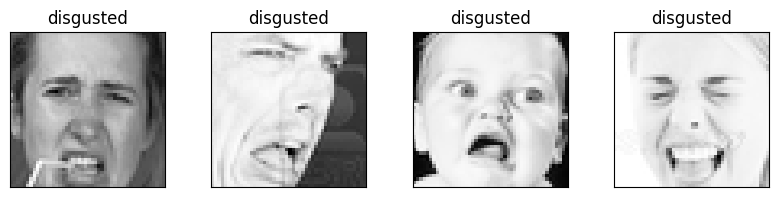

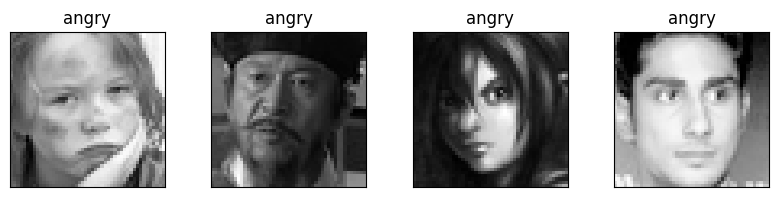

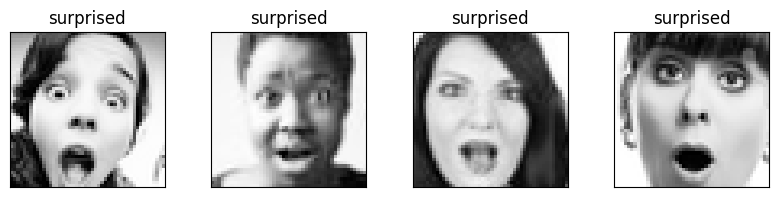

In [20]:
for i in range(len(categories_name_train)):
    plt.figure(figsize=(8,10))
    path = f"./data/train/{categories_name_train[i]}"
    
    for j in range(1,5):
        plt.subplot(3,4,j)
        plt.tight_layout()
        rand_img = Image.open(path +'/'+ np.random.choice(sorted(os.listdir(path))))
        plt.imshow(rand_img, cmap='Greys_r')

        # Don't print the X and Y coordinates on the side of the images.
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{categories_name_train[i]}")

---

## Data transformation

### Create tensorflow dataset

Checking the size of one image

In [21]:
image_path = "./data/train/happy/im0.png"
image = Image.open(image_path)
print(f"Image width: {image.width}.")
print(f"Image height: {image.height}.")

Image width: 48.
Image height: 48.


Check if 10 random images extracted from different categories have the same size, otherwhise raise an error message.

In [22]:
for i in range(10):
    random_category = categories_name_train[np.random.randint(7)]
    cat_path = f"./data/train/{random_category}"
    image_idx = np.random.randint(len(os.listdir(cat_path)))
    image_path = f"./data/train/{random_category}/im{image_idx}.png"
    image = Image.open(image_path)
    if i == 0:
        width = image.width
        height = image.height
    if image.width != width or image.height != height:
        raise ValueError(f"Found an image of diferent size:\n({image.width}X{image.height}) != ({width}X{height})")

print(f"The width of the images is {width}.\nThe height of the images is {height}.")

The width of the images is 48.
The height of the images is 48.


Use the `image_dataset_from_directory()` function to process the images and split the data in `training_dataset` and `validation_dataset`.

Referece: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [23]:
training_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                    directory = "./data/train", # path to the main folder
                    labels='inferred',  # infer the labels from the parent directory
                    label_mode='int',   # sparse_categorical_crossentropy loss
                    color_mode='grayscale',
                    image_size=(width, height), # add the size of the images so they're not scaled to 256x256
                    shuffle=True,
                    seed=16,
                    verbose=True,
                    batch_size=8, 
                    validation_split=0.1, # reserve a 10% from the training data for validation
                    subset="both", # returns the validation and train data
                    data_format="channels_last",
)

Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Using 2870 files for validation.


Check how many elements have of the training and validation datasets.

In [24]:
print(f"The training dataset has: {len(training_dataset.file_paths)} elements.")
print(f"The validation dataset has: {len(validation_dataset.file_paths)} elements.")

The training dataset has: 25839 elements.
The validation dataset has: 2870 elements.


Check the names of the classes created in train and test are the same

In [25]:
print(f"The validation dataset has these classes:{validation_dataset.class_names}.")
print(f"The training dataset has these classes: {training_dataset.class_names}.")

The validation dataset has these classes:['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'].
The training dataset has these classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'].


Ensure the batch size has the desired shape

In [26]:
# for batch in training_dataset:
#     print(batch[0][0][:10])
#     break

### Data augmentation/distortion

The dataset has the same images, but they are transformed differently for each epoch. 

**Tensorflow Random Transformation** has been used to transform the images to give to the model more variety. Link to the documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#augment_a_dataset_and_train_a_model_with_it 

In [27]:
print(f"The training dataset has: {len(training_dataset)} elements.")

The training dataset has: 3230 elements.


In [28]:
def augment_data(image, label):
    print(f"first_image: {image}")
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image,lower=0.0, upper=1.0)
    return image, label

training_dataset = training_dataset.map(augment_data)
training_dataset

first_image: Tensor("args_0:0", shape=(None, 48, 48, 1), dtype=float32)


<_MapDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
print(f"The training dataset has: {len(training_dataset)} elements.")

The training dataset has: 3230 elements.


Check how the first 5 augmented image in the first batch looks like

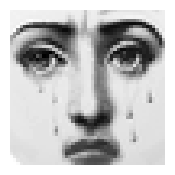

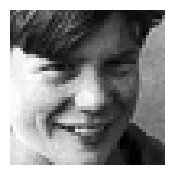

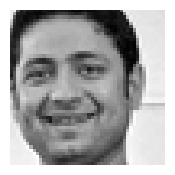

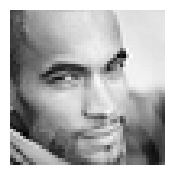

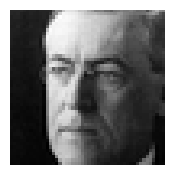

In [30]:
for batch in training_dataset:
    for i in range(5):
        image = batch[0][i]
        plt.figure(figsize=(2, 3))
        plt.imshow(image, cmap='gray')
        # plt.title("Augmented Image")
        plt.axis('off')
        
        plt.show()
    break

---

### Normalize the data 

Change the data distribution from (0, 1) to (-1, 1). By using division or multiplication, you'll never get smaller than 0, so the `-1` is needed. 

In [31]:
def normalize_data(image, label):
    image = tf.cast(2*image/255-1, tf.float32)
    return image, label

In [32]:
training_dataset = training_dataset.map(normalize_data)
validation_dataset = validation_dataset.map(normalize_data)

CHeck if the data has been normalized

In [33]:
for batch in training_dataset:
    print(batch[0][0][0][:10])
    break

tf.Tensor(
[[-0.14428937]
 [-0.15347564]
 [-0.16725498]
 [-0.18792403]
 [-0.20285165]
 [-0.21088958]
 [-0.22696549]
 [-0.23155856]
 [-0.23041034]
 [-0.24648625]], shape=(10, 1), dtype=float32)


---

## Model

### Dummy classifier

A model that predics always the majority class of the dataset.

In [34]:
def get_class_length(class_name):
    path = f"./data/train/{class_name}"
    return len(os.listdir(path))

In [35]:
all_training_images = 0
max_image_class = 0
for i in range(len(categories_name_train)):
    now_class = get_class_length(categories_name_train[i])
    all_training_images += now_class
    if now_class > max_image_class:
        max_image_class = now_class
    
all_training_images = max_image_class/all_training_images
print(f"The dummy model has an accuracy of:{all_training_images: .2f}%")

The dummy model has an accuracy of: 0.25%


### CNN model

#### Define the model architecture and configuration

Define the architecture of a CNN model with:
- `Conv2D()` layers that will extract features from the image. Link to the reference: https://keras.io/api/layers/convolution_layers/convolution2d/ 
- `Flatten()` layers, `Global Average Pooling` and `Global Max Pooling` can also be used, will transform the output of the convolutional layers into a 1D vector.
- `Dropout()` layers, randomly sets input units to 0 with a frequency of rate at each during the reaining time. https://keras.io/api/layers/regularization_layers/dropout/ 
- `Dense()` layers,  process the extracted features and produce the final predictions.

Link to compile reference: https://keras.io/api/models/model_training_apis/

In [36]:
model = Sequential()

# Add the shape of the input when the model.summary() doesn't work.
model.add(Input(shape=(48, 48, 1))), 

model.add(Conv2D(
    # Output space
    32, 
    kernel_size = 3,

    # Movement of the kernel over the image
    strides = 2,
    
    # Padding = "valid" does not add padding and returns a smaller output, 
    # Padding = "same" adds padding and returns an output of the same size. 
    padding="same",  

    # chanel_last = (height, width, channels) -> usually for TensorFlow / Keras
    # chanel_first =  (channels, height, width)
    # data_format="chanel_last", 

    # Skip pixels when passing with the kernel. 
    # Used when general patterns need to be detected.
    dilation_rate=(1, 1),
    
    # default = 1, if higher the input channels are split and a separate conv operation is performed on each group
    groups=1,

    # relu: hidden layers os CNN -> non-linearity
    # leaky-relu: hidden layers with "dead neurons"
    # softmax: last layer -> multi-class
    # sigmoid: last layer -> binary class
    activation='relu',

    # If True, helps the model learn features more effectively
    # Needs to be False if a BatchNorm layer is added straight after the layer.
    use_bias=True,
    ))
model.add(Conv2D(
    64, 
    kernel_size = 3,
    strides = 2,
    padding="same",
    # data_format="chanel_last", 
    groups=1,
    activation='relu',
    use_bias=True,
    ))
model.add(Conv2D(
    68, 
    kernel_size = 3,
    strides = 2,
    padding="same",
    # data_format="chanel_last", 
    groups=1,
    activation='relu',
    use_bias=True,
    ))
model.add(Conv2D(
    128, 
    kernel_size = 3,
    strides = 2,
    padding="same",
    # data_format="chanel_last", 
    groups=1,
    activation='relu',
    use_bias=True,
    ))
model.add(GlobalAveragePooling2D())
model.add(Flatten()) # Transform the complex multi-dimensional matrix in 1D vector
model.add(Dropout(0.5))
model.add(Dense(7, activation = "softmax")) # Expects a 1D input

In [37]:
# Define the model's configuration
model.compile(
    optimizers.Adam(0.001),
    loss="sparse_categorical_crossentropy",
    metrics =["accuracy"],
)

Check the summary of the model to understand the number of parameters.

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 68)       │        39,236 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │        78,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,419 (536.79 KB)

 Trainable params: 137,419 (536.79 KB)

 Non-trainable params: 0 (0.00 B)

Check the input and output shape of each layer of the model

In [39]:
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

---

#### Train the model

In [40]:
hist = model.fit(
    training_dataset,
    batch_size=8,
    epochs=100,
    verbose="auto",
    validation_data=validation_dataset,
    shuffle=True, 
)

Epoch 1/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.2418 - loss: 1.8184 - val_accuracy: 0.2763 - val_loss: 1.7621
Epoch 2/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.2765 - loss: 1.7587 - val_accuracy: 0.3530 - val_loss: 1.6221
Epoch 3/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.3417 - loss: 1.6520 - val_accuracy: 0.3934 - val_loss: 1.5529
Epoch 4/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.3819 - loss: 1.5723 - val_accuracy: 0.4174 - val_loss: 1.4955
Epoch 5/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.4031 - loss: 1.5255 - val_accuracy: 0.4153 - val_loss: 1.4891
Epoch 6/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.4234 - loss: 1.4853 - val_accuracy: 0.4432 - val_loss: 1.4352
Epoch 7/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.4346 - loss: 1.4480 - val_accuracy: 0.4537 - val_loss: 1.4144
Epoch 8/100
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.4511 - loss: 1

In [41]:
# Print the maximum accuracy
print(f"The maximum accuracy is: {max(hist.history['val_accuracy']):.4f}")

The maximum accuracy is: 0.5091


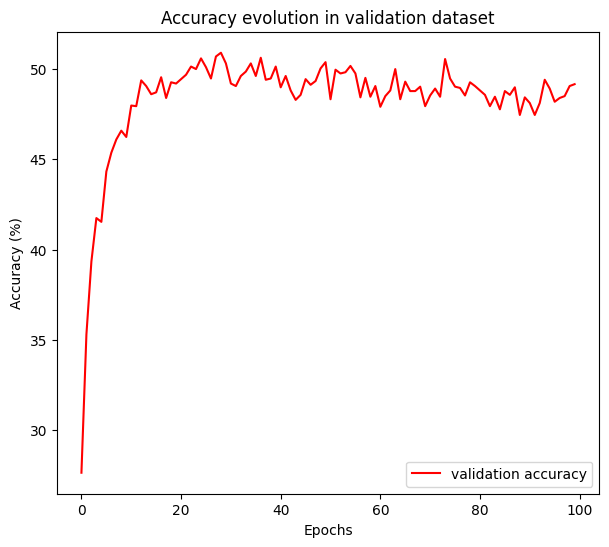

In [42]:
# Plot the accuracy in each epoch for the validation dataset
fig, ax = plt.subplots(1,1, figsize = (7,6))
ax.plot(np.array(hist.history["val_accuracy"])*100, label="validation accuracy", color="red")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Accuracy evolution in validation dataset")
ax.legend(loc = "lower right")
plt.show()

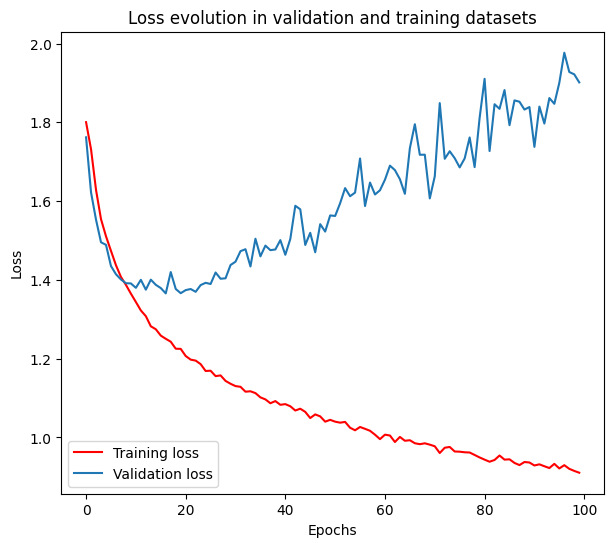

In [43]:
# Plot the Loss in each epoch for the training and validation datasets
fig2, ax = plt.subplots(1,1, figsize = (7,6))
ax.plot(hist.history["loss"], label="Training loss", color = "red")
ax.plot(hist.history["val_loss"], label="Validation loss")
#plt.xlim(0, 10)
#plt.ylim(0, 4)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution in validation and training datasets")
ax.legend(loc = "lower left")
plt.show()

### Save the data

In [44]:
# Create the dictionary with the model params and the metadata
state_dict = {
            "model_cls": str(model.__class__),
            "params": model.to_json(),
            "metrics":{
                "training_accuracy": hist.history["accuracy"],
                "training_loss": hist.history["loss"],
                "validation_accuracy": hist.history["val_accuracy"],
                "validation_loss": hist.history["val_loss"],
            },
            "meta":{
                "date": datetime.now().isoformat(),
                "student": "Maria Magdalena Balos",
                "course": "DATAMECUM-IA GENERATIVE MASTER",
            },
            }

# Save the json file
dirname = f"{datetime.now().isoformat()}"+"-"+ "CNN"
out_dir = os.path.join(".", "results", dirname)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    with open(os.path.join(out_dir, "state_dict.json"), "w") as f:
        json.dump(state_dict,f, indent=4)
    fig.savefig(os.path.join(out_dir, "accuracy_val.pdf"))
    fig2.savefig(os.path.join(out_dir, "loss_train_val.pdf"))

---

#### Evaluation

Method used to evaluate the performance of a trained model on a given dataset

In [45]:
training_loss, training_accuracy = model.evaluate(training_dataset, batch_size = 8, verbose = 0)
print(f"Training loss: {training_loss: .4f}. Validation accuracy: {training_accuracy: .4f}")

Training loss:  0.7102. Validation accuracy:  0.7463


In [46]:
validation_loss, validation_accuracy = model.evaluate(validation_dataset, batch_size = 8, verbose = 0)
print(f"Validation loss: {training_loss: .4f}. Validation accuracy: {training_accuracy: .4f}")

Validation loss:  0.7102. Validation accuracy:  0.7463


In [47]:
# When happy with the val_accuracy try it out in test